### ROC Curves, Imbalanced Classes

In this lab/lecture, we will learn about imbalanced classes and ROC curves, a more sophisticated measure of classifier performance than outputing just an error rate.

ROC curves work in the context of Binary classification. And they capture the tradeoff between the True Positive and False positive percentages. A perfect classifier would have 100% true positive percentage, meaning that it classified all the elements in the positive class as being positive and it made no errors in misclassifying the elements in the negative class as being positive. 

True Positive Percentage = (# True Positives) / (# All Positives)

False Positive Percentage = (# False Positives) / (# All Negatives)

Although this is possible, in reality, as you increase the true positive percentage, you also increase the false positive percentage. The ROC curve captures this relationship. 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             accuracy_score, roc_auc_score)

https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

In [4]:
df = pd.read_csv('data/blood_donations.csv', index_col = 'Unnamed: 0')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 619 to 74
Data columns (total 5 columns):
Months since Last Donation     576 non-null int64
Number of Donations            576 non-null int64
Total Volume Donated (c.c.)    576 non-null int64
Months since First Donation    576 non-null int64
Made Donation in March 2007    576 non-null int64
dtypes: int64(5)
memory usage: 27.0 KB


In [6]:
df.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [7]:
df.columns = ['Months_since_Last', 'Num_of_Donations', 'Total_Vol_Donated',
              'Months_since_First', 'Donation_March_2007']

In [6]:
df.head()

,Months_since_Last,Num_of_Donations,Total_Vol_Donated,Months_since_First,Donation_March_2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [7]:
df.Donation_March_2007.value_counts()

0    438
1    138
dtype: int64

In [8]:
# split the features from the target
X = df.drop('Donation_March_2007', axis = 1)
y = df.Donation_March_2007

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# train logistic regression, evaluate on test
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
    
#clf = train_test(data_out)
y_pred = lr.predict(X_test)

In [9]:
# just using the accuracy score can be misleading
accuracy_score(y_test, y_pred)

0.80924855491329484

In [10]:
# the accuracy score is just showing the percentage of predictions that match the targets
np.mean(y_test == y_pred)

0.80924855491329484

### Exercise: Using the confusion matrix calculate the precision and recall scores

Precision and recall on page 35 on lecture slides:

https://github.com/ga-students/DAT_SF_14/blob/master/slides/lec14.pdf

In [26]:
cm = confusion_matrix(y_pred,y_test)
cm

array([[134,  33],
       [  0,   6]])

Confusion Matrix Layout

In [12]:
# 0, 1
#['True Positive', 'False Positive']
# ['False Negative', 'True Negative']

In [29]:
# Precision for "No donation"
print 'Precision for "No donation":', 134.0/(134+33)
# Precision for "Donated"
print 'precision for "Donated":',6.0/(6+0) 

# Recall for "No donation"
print 'Recall for "No donation":', 134.0/(134+0)

# Recall for "Donated"
print 'Recall for "Donated":',6.0/(33+6)

Precision for "No donation": 1.0
precision for "Donated": 0.802395209581
Recall for "No donation": 0.153846153846
Recall for "Donated": 1.0


In [17]:
# evaluate accuracy
print "Train Testing Results \n\n"

print classification_report(y_test, y_pred, target_names=['no donation', 'donated'])

Train Testing Results 


             precision    recall  f1-score   support

no donation       0.80      1.00      0.89       134
    donated       1.00      0.15      0.27        39

avg / total       0.85      0.81      0.75       173



In [37]:
target_names=['no donation', 'donated']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #interesting
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

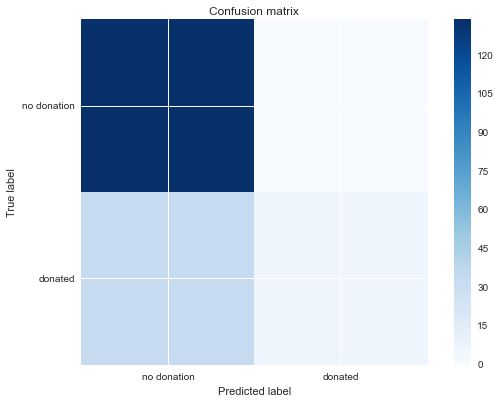

In [16]:
plot_confusion_matrix(cm, title='Confusion matrix')

## Model evaluation and interpretation, with ROC

Logistic Regression is a probabilistic model: instead of just predicting a binary outcome (donated or not) given the input features it can also estimates the probability of the outcome given the input features using the `predict_proba` method:

In [13]:
p_proba = lr.predict_proba(X_test)

In [14]:
# predicted probabilities of '0' and '1' respectively
p_proba[:5]

array([[ 0.61833774,  0.38166226],
       [ 0.68307696,  0.31692304],
       [ 0.76134106,  0.23865894],
       [ 0.89087711,  0.10912289],
       [ 0.8973795 ,  0.1026205 ]])

In [15]:
# any probability > .5 will have a 1 prediction
zip(y_pred, p_proba[:,1])

[(0, 0.38166226437909845),
 (0, 0.31692304005584049),
 (0, 0.23865893662739288),
 (0, 0.10912289304290568),
 (0, 0.10262049883424726),
 (0, 0.13034426412822195),
 (0, 0.056996560288721715),
 (0, 0.14262461269908849),
 (0, 0.16314434882523093),
 (0, 0.17823601047095869),
 (0, 0.16755083815563135),
 (0, 0.10206002710210955),
 (0, 0.19759609681390936),
 (0, 0.19822764696942993),
 (0, 0.29134703336528212),
 (0, 0.25579890888219925),
 (0, 0.15161903559572995),
 (1, 0.92173725785451566),
 (0, 0.21333375733012444),
 (0, 0.31025730714601957),
 (0, 0.19886798092056324),
 (0, 0.35161210506313983),
 (0, 0.10912289304290568),
 (0, 0.098629153730036737),
 (0, 0.27687443038522802),
 (0, 0.48929463183854449),
 (1, 0.53585215324509283),
 (0, 0.095880918957298639),
 (0, 0.22865786447822495),
 (0, 0.33529954344796647),
 (0, 0.16950116332640494),
 (0, 0.05415658267211497),
 (0, 0.36757168396028023),
 (0, 0.06913709764805967),
 (0, 0.49928596509314066),
 (0, 0.21292907988607793),
 (0, 0.093617754999911776

In [16]:
zip(y_test, p_proba[:,1])[:10]

[(1, 0.38166226437909845),
 (1, 0.31692304005584049),
 (0, 0.23865893662739288),
 (0, 0.10912289304290568),
 (0, 0.10262049883424726),
 (0, 0.13034426412822195),
 (1, 0.056996560288721715),
 (0, 0.14262461269908849),
 (0, 0.16314434882523093),
 (0, 0.17823601047095869)]

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curve and quantifying the Area under the ROC curve:

In [17]:
def plot_roc_curve(y_test, p_proba):
    # calculates: false positive rate, true positive rate, 
    fpr, tpr, thresholds = roc_curve(y_test, p_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label= 'AUC = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC')
    plt.legend(loc="lower right")

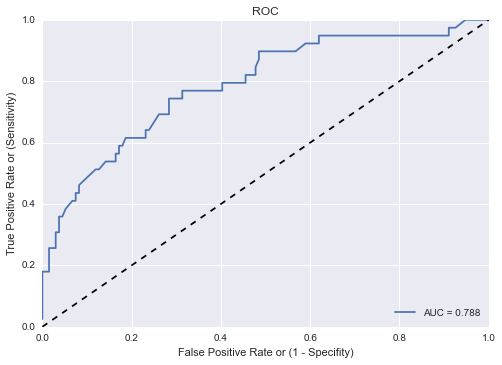

In [18]:
plot_roc_curve(y_test, p_proba)

## Let's downsample the majority class to train our classifer and see if we can get better performance

To do this, we will train our logistic regression classifier with downsampled data and use this trained classifier on the non-downsampled data to see if it can do a better job

In [30]:
# get equal sample sizes of both classes
class_sample = df.Donation_March_2007.value_counts()[1]

# get a subset of the data frame with no donations
no_donation_idx = df[df.Donation_March_2007 == 0].index

# take a equal random sample of no donation rows
sample_rows = random.sample(no_donation_idx, class_sample)

# concat subset data frames back together
df_ds = pd.concat([df.ix[sample_rows], df[df.Donation_March_2007 == 1]])

In [31]:
df_ds.Donation_March_2007.value_counts()

1    138
0    138
dtype: int64

In [38]:
# separate features and target
X_ds = df_ds.drop('Donation_March_2007', axis = 1)
y_ds = df_ds.Donation_March_2007

# train test split
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_ds, y_ds, test_size=0.3, random_state=0)

# train logistic regression, evaluate on test
lr_ds = LogisticRegression(C=1)
lr_ds.fit(X_train_ds, y_train_ds)
    
#clf = train_test(data_out)
y_pred_ds = lr_ds.predict(X_test_ds)
    
#evaluate accuracy
print "Train Testing Results \n\n"

print classification_report(y_test_ds, y_pred_ds, target_names=['no donation', 'donated'])

Train Testing Results 


             precision    recall  f1-score   support

no donation       0.64      0.61      0.62        38
    donated       0.68      0.71      0.70        45

avg / total       0.66      0.66      0.66        83



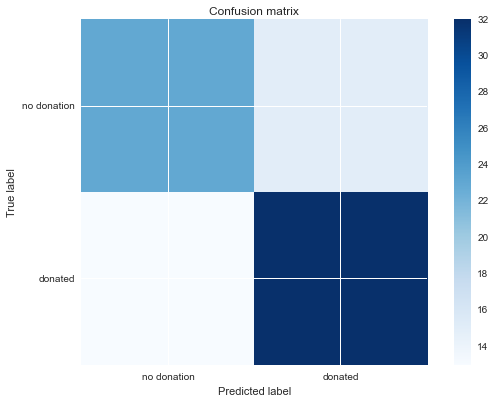

In [39]:
cm_ds = confusion_matrix(y_test_ds, y_pred_ds)

plot_confusion_matrix(cm_ds, title='Confusion matrix')

In [40]:
cm_ds

array([[23, 15],
       [13, 32]])

####Now that we have this classifier trained on downsampled data, let's see if it performs better with the full dataset. Note that we are testing the classifier "lr_ds" with 'X_test' not 'X_test_ds'

In [41]:
y_pred = lr_ds.predict(X_test)
    
#evaluate accuracy
print("Train Testing Results With Downsampling the No Donation class \n\n")

print(classification_report(y_test, y_pred,
                         target_names=['no donation', 'donated']))
    

Train Testing Results With Downsampling the No Donation class 


             precision    recall  f1-score   support

no donation       0.91      0.68      0.78       134
    donated       0.41      0.77      0.54        39

avg / total       0.80      0.70      0.72       173



In [44]:
cm_ds = confusion_matrix(y_pred, y_test)

In [45]:
# new confusion matrix, fit from downsampled data and predicted using full data set
cm_ds

array([[91,  9],
       [43, 30]])

In [46]:
# original confusion matrix, fit and predicted using full data set
cm

array([[134,  33],
       [  0,   6]])

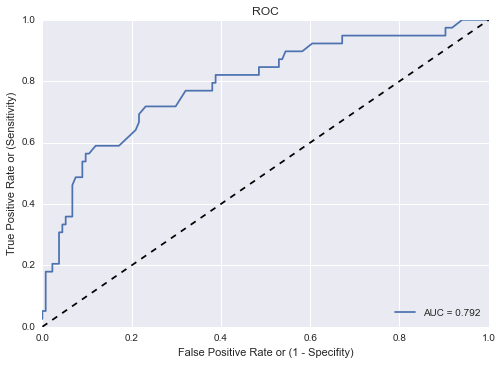

In [47]:
# getting predicted probabilities from downsampled classifier
p_proba_ds = lr_ds.predict_proba(X_test)

# plotting ROC curve
plot_roc_curve(y_test, p_proba_ds)

## Another Strategy ... Adjusting Class Weights 

### Setting class_weights equal to 'auto', selects weights inversely proportional to class frequencies in the training set.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [19]:
# separate original features and target
X = df.drop('Donation_March_2007', axis = 1)
y = df.Donation_March_2007

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LogisticRegression(C=1, class_weight= 'auto') #also in SVM - this looks at how many labels are in each class to re
lr.fit(X_train, y_train)
    
y_pred = lr.predict(X_test)
    
print "Train Testing Results \n\n"

print classification_report(y_test, y_pred, target_names=['no donation', 'donated'])

Train Testing Results 


             precision    recall  f1-score   support

no donation       0.91      0.68      0.78       134
    donated       0.41      0.77      0.54        39

avg / total       0.80      0.70      0.72       173



In [21]:
cm_auto_weight = confusion_matrix(y_pred, y_test)
cm_auto_weight

array([[91,  9],
       [43, 30]])

## Exercises:

### Calculate the predicted probabilities and plot the ROC curve

In [35]:
# use the last classifier with class_weight = 'auto'

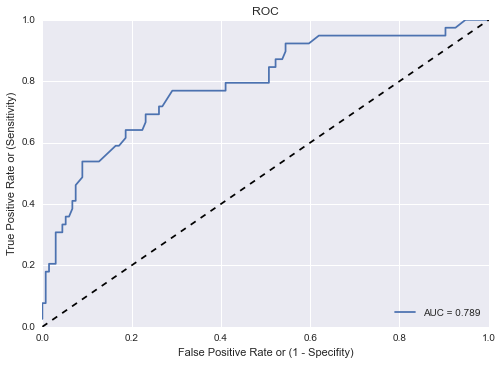

In [22]:
# get the predicted probabilities from the last classifier with class_weight = 'auto'
# getting predicted probabilities from downsampled classifier
p_proba = lr.predict_proba(X_test)

# plotting ROC curve
plot_roc_curve(y_test, p_proba)

# plot ROC curve



### Using the classifier algorithms below plot the ROC and maximize AUC value

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

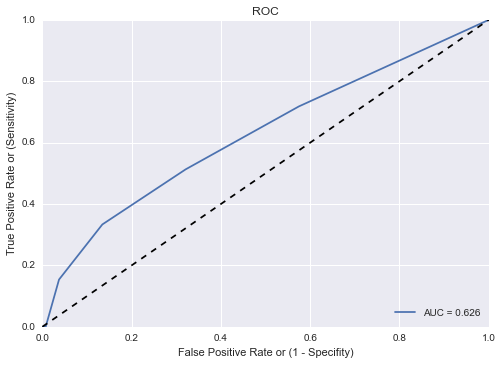

In [38]:
# Example code

rf = KNeighborsClassifier()
rf.fit(X_train, y_train)
p_proba = rf.predict_proba(X_test)
plot_roc_curve(y_test, p_proba)

In [23]:
# Example code

roc_auc_score(y_test, p_proba[:,1])

0.78922694221201684

###By the way...

This data set is from a data science competition. If you get a chance submit your best model!

http://www.drivendata.org/competitions/2/